In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
from ipywidgets import FloatSlider, interactive

In [2]:
method_l = [
    "maxcorr", 
    "mincorr", 
    "maxlinreg", 
    "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results8_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["maxcorr"]["corrs"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["maxcorr"]["corrs"][network].values()))) # god this is a hack

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [4]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [5]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        print(network, method)
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

bert_large_cased-ptb_pos_dev.hdf5_0 maxlinreg
bert_large_cased-ptb_pos_dev.hdf5_0 minlinreg
bert_large_cased-ptb_pos_dev.hdf5_0 maxcorr
bert_large_cased-ptb_pos_dev.hdf5_0 mincorr
bert_large_cased-ptb_pos_dev.hdf5_1 maxlinreg
bert_large_cased-ptb_pos_dev.hdf5_1 minlinreg
bert_large_cased-ptb_pos_dev.hdf5_1 maxcorr
bert_large_cased-ptb_pos_dev.hdf5_1 mincorr
bert_large_cased-ptb_pos_dev.hdf5_2 maxlinreg
bert_large_cased-ptb_pos_dev.hdf5_2 minlinreg
bert_large_cased-ptb_pos_dev.hdf5_2 maxcorr
bert_large_cased-ptb_pos_dev.hdf5_2 mincorr
bert_large_cased-ptb_pos_dev.hdf5_3 maxlinreg
bert_large_cased-ptb_pos_dev.hdf5_3 minlinreg
bert_large_cased-ptb_pos_dev.hdf5_3 maxcorr
bert_large_cased-ptb_pos_dev.hdf5_3 mincorr
bert_large_cased-ptb_pos_dev.hdf5_4 maxlinreg
bert_large_cased-ptb_pos_dev.hdf5_4 minlinreg
bert_large_cased-ptb_pos_dev.hdf5_4 maxcorr
bert_large_cased-ptb_pos_dev.hdf5_4 mincorr
bert_large_cased-ptb_pos_dev.hdf5_5 maxlinreg
bert_large_cased-ptb_pos_dev.hdf5_5 minlinreg
bert_lar

In [6]:
res_d["mincorr"]["neuron_sort"]

{'bert_large_cased-ptb_pos_dev.hdf5_0': [16,
  521,
  809,
  511,
  783,
  58,
  896,
  492,
  94,
  2,
  318,
  208,
  38,
  76,
  287,
  761,
  413,
  784,
  156,
  179,
  277,
  482,
  842,
  99,
  379,
  69,
  246,
  319,
  226,
  565,
  305,
  765,
  307,
  273,
  826,
  816,
  634,
  25,
  449,
  789,
  865,
  991,
  997,
  854,
  567,
  389,
  284,
  554,
  600,
  563,
  450,
  877,
  225,
  864,
  597,
  220,
  408,
  205,
  544,
  361,
  640,
  302,
  265,
  532,
  602,
  520,
  354,
  132,
  618,
  667,
  691,
  151,
  209,
  665,
  342,
  338,
  928,
  137,
  79,
  42,
  264,
  518,
  571,
  882,
  233,
  437,
  703,
  845,
  399,
  545,
  483,
  123,
  1001,
  193,
  929,
  658,
  839,
  425,
  1015,
  772,
  343,
  886,
  258,
  846,
  432,
  168,
  1018,
  218,
  92,
  875,
  314,
  965,
  625,
  760,
  436,
  536,
  206,
  104,
  423,
  426,
  298,
  471,
  889,
  454,
  861,
  961,
  709,
  680,
  384,
  494,
  230,
  599,
  786,
  1002,
  375,
  397,
  86,
  979,
  172

In [7]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [8]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_large_cased-ptb_pos_dev.hdf5_0
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0.267580  0.648590  0.176786
minlinreg   0.267580   1.000000 -0.205276  0.841955
maxcorr     0.648590  -0.205276  1.000000 -0.265459
mincorr     0.176786   0.841955 -0.265459  1.000000
bert_large_cased-ptb_pos_dev.hdf5_1
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0.278006  0.966641  0.035100
minlinreg   0.278006   1.000000  0.214889  0.745113
maxcorr     0.966641   0.214889  1.000000 -0.017520
mincorr     0.035100   0.745113 -0.017520  1.000000
bert_large_cased-ptb_pos_dev.hdf5_2
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0.450775  0.977873  0.131423
minlinreg   0.450775   1.000000  0.434118  0.741115
maxcorr     0.977873   0.434118  1.000000  0.115594
mincorr     0.131423   0.741115  0.115594  1.000000
bert_large_cased-ptb_pos_dev.hdf5_3
           maxlinreg  minlinreg   maxcorr   mincorr
maxlinreg   1.000000   0

### Distributions

In [9]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_large_cased-ptb_pos_dev.hdf5_0:

maxlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_1    1021
bert_base_cased-ptb_pos_dev.hdf5_0        3
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     1011
xlnet_large_cased-ptb_pos_dev.hdf5_0         8
openai_transformer-ptb_pos_dev.hdf5_12       4
elmo_original-ptb_pos_dev.hdf5_0             1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.267581  0.391111
min  0.267581  1.000000  0.936521
med  0.391111  0.936521  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_1    1021
bert_base_cased-ptb_pos_dev.hdf5_0        3
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     1011
xlnet_large_cased-ptb_pos_dev.hdf5_0         8
openai_transformer-ptb_pos_dev.hdf5_12       4
elmo_original-ptb_pos_dev.hdf5_0             1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.267581  0.391111
min  0.267581  1.000000  0.936521
med  0.391111  0.936521  

          max       min       med
max  1.000000 -0.017512  0.111634
min -0.017512  1.000000  0.825472
med  0.111634  0.825472  1.000000

mincorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_2    955
bert_large_cased-ptb_pos_dev.hdf5_0     69
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                625
xlnet_large_cased-ptb_pos_dev.hdf5_20                 46
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    42
xlnet_large_cased-ptb_pos_dev.hdf5_22                 41
xlnet_large_cased-ptb_pos_dev.hdf5_16                 32
xlnet_large_cased-ptb_pos_dev.hdf5_21                 27
xlnet_large_cased-ptb_pos_dev.hdf5_14                 27
xlnet_large_cased-ptb_pos_dev.hdf5_19                 26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 21
xlnet_large_cased-ptb_pos_dev.hdf5_17                 21
xlnet_large_cased-ptb_pos_dev.hdf5_18                 19
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    17
xlnet_large_cased-ptb_pos_dev.hdf5_12             

         max       min       med
max  1.00000  0.098180  0.203270
min  0.09818  1.000000  0.855122
med  0.20327  0.855122  1.000000


bert_large_cased-ptb_pos_dev.hdf5_4:

maxlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_5    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                837
openai_transformer-ptb_pos_dev.hdf5_12               141
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    16
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     15
elmo_original-ptb_pos_dev.hdf5_0                      14
openai_transformer-ptb_pos_dev.hdf5_0                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.415928  0.703112
min  0.415928  1.000000  0.884590
med  0.703112  0.884590  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_5    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                837
openai_transformer-ptb_pos_dev.hdf5_12               141
elmo_4x4096_512-ptb_pos_dev.hd

bert_large_cased-ptb_pos_dev.hdf5_7    1023
bert_large_cased-ptb_pos_dev.hdf5_5       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                499
openai_transformer-ptb_pos_dev.hdf5_12               426
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     39
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    38
elmo_original-ptb_pos_dev.hdf5_0                      16
xlnet_large_cased-ptb_pos_dev.hdf5_0                   3
openai_transformer-ptb_pos_dev.hdf5_0                  3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.557767  0.755753
min  0.557767  1.000000  0.915722
med  0.755753  0.915722  1.000000

maxcorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_7                  780
bert_large_cased-ptb_pos_dev.hdf5_5                  243
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                626
xlnet_large_cased-ptb_pos_dev.hdf5_22                 

          max       min       med
max  1.000000  0.611752  0.809077
min  0.611752  1.000000  0.921535
med  0.809077  0.921535  1.000000

maxcorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_7                  612
bert_large_cased-ptb_pos_dev.hdf5_9                  411
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                616
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    46
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    40
xlnet_large_cased-ptb_pos_dev.hdf5_22                 40
xlnet_large_cased-ptb_pos_dev.hdf5_16                 29
xlnet_large_cased-ptb_pos_dev.hdf5_20                 24
xlnet_large_cased-ptb_pos_dev.hdf5_15                 17
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6     14
xlnet_large_cased-ptb_pos_dev.hdf5_18                 13
xlnet_large_cased-ptb_pos_dev.hdf5_14                 13
xlnet_large_cased-ptb_pos_dev.hdf5_17                 13
elmo_original-ptb_pos_

          max      min       med
max  1.000000  0.28901  0.444645
min  0.289010  1.00000  0.839040
med  0.444645  0.83904  1.000000

mincorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_9     974
bert_large_cased-ptb_pos_dev.hdf5_11     50
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                580
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    43
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    42
xlnet_large_cased-ptb_pos_dev.hdf5_22                 32
xlnet_large_cased-ptb_pos_dev.hdf5_16                 29
xlnet_large_cased-ptb_pos_dev.hdf5_20                 29
xlnet_large_cased-ptb_pos_dev.hdf5_19                 20
xlnet_large_cased-ptb_pos_dev.hdf5_18                 19
openai_transformer-ptb_pos_dev.hdf5_12                18
xlnet_large_cased-ptb_pos_dev.hdf5_15                 18
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    17
elmo_original-ptb_pos_dev.hdf5_0                      16
xlnet_large_cased-ptb_pos_dev.hdf5_13               


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_11                 822
bert_large_cased-ptb_pos_dev.hdf5_13                 201
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                620
xlnet_large_cased-ptb_pos_dev.hdf5_22                 53
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    36
xlnet_large_cased-ptb_pos_dev.hdf5_20                 26
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    24
openai_transformer-ptb_pos_dev.hdf5_12                19
xlnet_large_cased-ptb_pos_dev.hdf5_19                 18
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    16
xlnet_large_cased-ptb_pos_dev.hdf5_16                 15
xlnet_large_cased-ptb_pos_dev.hdf5_18                 14
xlnet_large_cased-ptb_pos_dev.hdf5_17                 13
openai_transformer-ptb_pos_dev.hdf5_0                 13
elmo_original-ptb_pos_dev.hdf5_0                      13
xlnet_large_cased-ptb_pos_dev.hdf5_15                


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_16    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   400
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    217
openai_transformer-ptb_pos_dev.hdf5_12               206
elmo_original-ptb_pos_dev.hdf5_0                     137
openai_transformer-ptb_pos_dev.hdf5_0                 37
xlnet_large_cased-ptb_pos_dev.hdf5_23                 14
xlnet_large_cased-ptb_pos_dev.hdf5_0                  10
bert_base_cased-ptb_pos_dev.hdf5_0                     2
openai_transformer-ptb_pos_dev.hdf5_1                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.876176  0.916833
min  0.876176  1.000000  0.954015
med  0.916833  0.954015  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_16    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   400
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    217
openai_transformer-ptb_pos_dev.hdf5_12 


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_18    1004
bert_large_cased-ptb_pos_dev.hdf5_16      20
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   480
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    223
openai_transformer-ptb_pos_dev.hdf5_12               130
elmo_original-ptb_pos_dev.hdf5_0                     130
openai_transformer-ptb_pos_dev.hdf5_0                 45
xlnet_large_cased-ptb_pos_dev.hdf5_0                  13
xlnet_large_cased-ptb_pos_dev.hdf5_23                  2
bert_base_cased-ptb_pos_dev.hdf5_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.858036  0.900049
min  0.858036  1.000000  0.939524
med  0.900049  0.939524  1.000000

maxcorr

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_16    561
bert_large_cased-ptb_pos_dev.hdf5_18    463
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                527
elmo_original-ptb_pos_dev.hdf5_0                      53
elmo_4x409


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_20    579
bert_large_cased-ptb_pos_dev.hdf5_18    444
xlnet_large_cased-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                403
elmo_original-ptb_pos_dev.hdf5_0                      83
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    59
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    55
openai_transformer-ptb_pos_dev.hdf5_0                 50
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    42
xlnet_large_cased-ptb_pos_dev.hdf5_1                  38
xlnet_large_cased-ptb_pos_dev.hdf5_2                  33
openai_transformer-ptb_pos_dev.hdf5_1                 23
openai_transformer-ptb_pos_dev.hdf5_12                22
xlnet_large_cased-ptb_pos_dev.hdf5_22                 18
bert_large_cased-ptb_pos_dev.hdf5_0                   15
elmo_original-ptb_pos_dev.hdf5_2                      14
bert_base_cased-ptb_pos_dev.hdf5_0                    12
xlnet_large_cased-ptb_pos_dev.hdf5_


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_19    920
bert_large_cased-ptb_pos_dev.hdf5_21    103
xlnet_large_cased-ptb_pos_dev.hdf5_0      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                385
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    83
elmo_original-ptb_pos_dev.hdf5_0                      63
openai_transformer-ptb_pos_dev.hdf5_0                 61
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    52
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    52
xlnet_large_cased-ptb_pos_dev.hdf5_2                  35
xlnet_large_cased-ptb_pos_dev.hdf5_1                  28
openai_transformer-ptb_pos_dev.hdf5_1                 23
openai_transformer-ptb_pos_dev.hdf5_12                19
elmo_original-ptb_pos_dev.hdf5_2                      18
bert_base_cased-ptb_pos_dev.hdf5_0                    14
bert_large_cased-ptb_pos_dev.hdf5_0                   11
elmo_4x4096_512-ptb_pos_dev.hdf5_1                    10
xlnet_large_cased-ptb_pos_dev.hdf5_


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_22    999
bert_large_cased-ptb_pos_dev.hdf5_20     25
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                327
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    90
elmo_original-ptb_pos_dev.hdf5_0                      73
openai_transformer-ptb_pos_dev.hdf5_0                 64
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    52
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    42
xlnet_large_cased-ptb_pos_dev.hdf5_1                  39
xlnet_large_cased-ptb_pos_dev.hdf5_2                  33
openai_transformer-ptb_pos_dev.hdf5_12                28
openai_transformer-ptb_pos_dev.hdf5_1                 22
elmo_4x4096_512-ptb_pos_dev.hdf5_4                    17
xlnet_large_cased-ptb_pos_dev.hdf5_3                  16
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6     14
bert_large_cased-ptb_pos_dev.hdf5_0                   12
xlnet_large_cased-ptb_pos_dev.hdf5_22                 12
elmo_4x4096_512-ptb_po


maxcounts
bert_large_cased-ptb_pos_dev.hdf5_23    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   441
openai_transformer-ptb_pos_dev.hdf5_12               257
elmo_original-ptb_pos_dev.hdf5_0                     146
xlnet_large_cased-ptb_pos_dev.hdf5_23                 73
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     53
openai_transformer-ptb_pos_dev.hdf5_0                 29
xlnet_large_cased-ptb_pos_dev.hdf5_0                  25
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.725235  0.765540
min  0.725235  1.000000  0.959911
med  0.765540  0.959911  1.000000

minlinreg

maxcounts
bert_large_cased-ptb_pos_dev.hdf5_23    1024
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   441
openai_transformer-ptb_pos_dev.hdf5_12               257
elmo_original-ptb_pos_dev.hdf5_0                     146
xlnet_large_cased-ptb_pos_dev.hdf5_23                 73
calypso_transformer_6_512_base-ptb_pos_


maxcounts
openai_transformer-ptb_pos_dev.hdf5_1    760
xlnet_large_cased-ptb_pos_dev.hdf5_1       4
openai_transformer-ptb_pos_dev.hdf5_2      2
bert_large_cased-ptb_pos_dev.hdf5_0        1
xlnet_large_cased-ptb_pos_dev.hdf5_0       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                756
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     4
elmo_original-ptb_pos_dev.hdf5_0                       4
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      2
openai_transformer-ptb_pos_dev.hdf5_12                 1
elmo_4x4096_512-ptb_pos_dev.hdf5_4                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.292286  0.367033
min  0.292286  1.000000  0.933603
med  0.367033  0.933603  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_1    760
xlnet_large_cased-ptb_pos_dev.hdf5_1       4
openai_transformer-ptb_pos_dev.hdf5_2      2
bert_large_cased-ptb_pos_dev.hdf5_0        1
xlnet_large_cased-ptb_pos_dev.hdf

          max       min       med
max  1.000000  0.367322  0.469574
min  0.367322  1.000000  0.940275
med  0.469574  0.940275  1.000000

maxcorr

maxcounts
openai_transformer-ptb_pos_dev.hdf5_2    711
openai_transformer-ptb_pos_dev.hdf5_0     53
openai_transformer-ptb_pos_dev.hdf5_8      1
openai_transformer-ptb_pos_dev.hdf5_3      1
openai_transformer-ptb_pos_dev.hdf5_7      1
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                368
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    65
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    43
xlnet_large_cased-ptb_pos_dev.hdf5_22                 35
bert_base_cased-ptb_pos_dev.hdf5_12                   24
xlnet_large_cased-ptb_pos_dev.hdf5_20                 22
xlnet_large_cased-ptb_pos_dev.hdf5_18                 17
elmo_4x4096_512-ptb_pos_dev.hdf5_4                    15
xlnet_large_cased-ptb_pos_dev.hdf5_21                 14
xlnet_large_cased-ptb_pos_dev.hdf5_16


maxcounts
openai_transformer-ptb_pos_dev.hdf5_5    762
openai_transformer-ptb_pos_dev.hdf5_3      5
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                755
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      8
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     4
elmo_original-ptb_pos_dev.hdf5_0                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.893606  0.946105
min  0.893606  1.000000  0.971207
med  0.946105  0.971207  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_5    762
openai_transformer-ptb_pos_dev.hdf5_3      5
openai_transformer-ptb_pos_dev.hdf5_6      1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                755
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      8
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     4
elmo_original-ptb_pos_dev.hdf5_0                       1
dtype: int64

corr_df_pctl
   


maxcounts
openai_transformer-ptb_pos_dev.hdf5_5    592
openai_transformer-ptb_pos_dev.hdf5_7    176
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                411
bert_large_cased-ptb_pos_dev.hdf5_24                  43
bert_base_cased-ptb_pos_dev.hdf5_12                   31
xlnet_large_cased-ptb_pos_dev.hdf5_22                 30
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    26
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 19
bert_large_cased-ptb_pos_dev.hdf5_23                  14
xlnet_large_cased-ptb_pos_dev.hdf5_21                 11
elmo_original-ptb_pos_dev.hdf5_0                      11
xlnet_large_cased-ptb_pos_dev.hdf5_13                 10
xlnet_large_cased-ptb_pos_dev.hdf5_18                  9
xlnet_large_cased-ptb_pos_dev.hdf5_16                  8
bert_large_cased-ptb_pos_dev.hdf5_4                    8
elmo_original-ptb_pos_dev.hdf5_2                       7
xlnet_large_cased-pt

          max       min       med
max  1.000000  0.690921  0.619401
min  0.690921  1.000000  0.874985
med  0.619401  0.874985  1.000000


openai_transformer-ptb_pos_dev.hdf5_9:

maxlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_10    536
openai_transformer-ptb_pos_dev.hdf5_8     232
dtype: int64

mincounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    324
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   199
xlnet_large_cased-ptb_pos_dev.hdf5_23                165
elmo_original-ptb_pos_dev.hdf5_0                      69
bert_base_cased-ptb_pos_dev.hdf5_0                     7
xlnet_large_cased-ptb_pos_dev.hdf5_0                   3
openai_transformer-ptb_pos_dev.hdf5_0                  1
dtype: int64

corr_df_pctl
         max       min       med
max  1.00000  0.922280  0.946410
min  0.92228  1.000000  0.963172
med  0.94641  0.963172  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_10    536
openai_transformer-ptb_pos_dev.hdf5_8     232
dtype: int64



maxcounts
openai_transformer-ptb_pos_dev.hdf5_11    482
openai_transformer-ptb_pos_dev.hdf5_9     286
dtype: int64

mincounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    283
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   225
elmo_original-ptb_pos_dev.hdf5_0                     130
xlnet_large_cased-ptb_pos_dev.hdf5_23                110
bert_base_cased-ptb_pos_dev.hdf5_0                    13
xlnet_large_cased-ptb_pos_dev.hdf5_0                   5
openai_transformer-ptb_pos_dev.hdf5_0                  2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.879997  0.927963
min  0.879997  1.000000  0.953658
med  0.927963  0.953658  1.000000

minlinreg

maxcounts
openai_transformer-ptb_pos_dev.hdf5_11    482
openai_transformer-ptb_pos_dev.hdf5_9     286
dtype: int64

mincounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    283
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   225
elmo_original-ptb_pos_dev.hdf5_0                     130
xl


maxcounts
openai_transformer-ptb_pos_dev.hdf5_10    429
openai_transformer-ptb_pos_dev.hdf5_12    339
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23    361
elmo_original-ptb_pos_dev.hdf5_0          38
xlnet_large_cased-ptb_pos_dev.hdf5_1      25
bert_large_cased-ptb_pos_dev.hdf5_24      20
bert_large_cased-ptb_pos_dev.hdf5_23      20
                                        ... 
elmo_4x4096_512-ptb_pos_dev.hdf5_1         1
bert_large_cased-ptb_pos_dev.hdf5_1        1
bert_large_cased-ptb_pos_dev.hdf5_15       1
xlnet_large_cased-ptb_pos_dev.hdf5_4       1
xlnet_large_cased-ptb_pos_dev.hdf5_10      1
Length: 62, dtype: int64

corr_df_pctl
          max      min       med
max  1.000000  0.50637  0.487758
min  0.506370  1.00000  0.915490
med  0.487758  0.91549  1.000000

mincorr

maxcounts
openai_transformer-ptb_pos_dev.hdf5_10    429
openai_transformer-ptb_pos_dev.hdf5_12    339
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23    361
elmo_original-ptb_pos_dev.


maxcounts
bert_base_cased-ptb_pos_dev.hdf5_2    410
bert_base_cased-ptb_pos_dev.hdf5_0    358
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                732
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    16
openai_transformer-ptb_pos_dev.hdf5_12                10
elmo_original-ptb_pos_dev.hdf5_0                       7
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.355886  0.524734
min  0.355886  1.000000  0.893653
med  0.524734  0.893653  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_2    410
bert_base_cased-ptb_pos_dev.hdf5_0    358
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                732
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    16
openai_transformer-ptb_pos_dev.hdf5_12                10
elmo_original-ptb_pos_dev.hdf5_0                       7
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      3
dtype: int64

corr

bert_base_cased-ptb_pos_dev.hdf5_4    595
bert_base_cased-ptb_pos_dev.hdf5_2    173
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                466
xlnet_large_cased-ptb_pos_dev.hdf5_22                 34
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    34
xlnet_large_cased-ptb_pos_dev.hdf5_20                 26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 25
xlnet_large_cased-ptb_pos_dev.hdf5_16                 25
xlnet_large_cased-ptb_pos_dev.hdf5_21                 22
xlnet_large_cased-ptb_pos_dev.hdf5_18                 17
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    16
xlnet_large_cased-ptb_pos_dev.hdf5_17                 15
xlnet_large_cased-ptb_pos_dev.hdf5_14                 10
xlnet_large_cased-ptb_pos_dev.hdf5_19                 10
xlnet_large_cased-ptb_pos_dev.hdf5_12                  8
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6      7
elmo_4x4096_512-ptb_pos_dev.hdf5_4                     7
xlnet_large_cased-ptb_pos_dev.hdf5_11

openai_transformer-ptb_pos_dev.hdf5_12               241
xlnet_large_cased-ptb_pos_dev.hdf5_23                227
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   168
elmo_original-ptb_pos_dev.hdf5_0                      61
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     57
openai_transformer-ptb_pos_dev.hdf5_0                 10
xlnet_large_cased-ptb_pos_dev.hdf5_0                   4
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.711085  0.799499
min  0.711085  1.000000  0.940840
med  0.799499  0.940840  1.000000

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_7    753
bert_base_cased-ptb_pos_dev.hdf5_5     15
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_12               241
xlnet_large_cased-ptb_pos_dev.hdf5_23                227
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   168
elmo_original-ptb_pos_dev.hdf5_0                      61
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     57
openai_transformer-ptb_

          max       min       med
max  1.000000  0.474738  0.499654
min  0.474738  1.000000  0.838979
med  0.499654  0.838979  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_9    408
bert_base_cased-ptb_pos_dev.hdf5_7    360
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                469
elmo_original-ptb_pos_dev.hdf5_0                      29
elmo_4x4096_512-ptb_pos_dev.hdf5_2                    29
xlnet_large_cased-ptb_pos_dev.hdf5_22                 27
openai_transformer-ptb_pos_dev.hdf5_0                 25
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    16
xlnet_large_cased-ptb_pos_dev.hdf5_1                  14
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    13
xlnet_large_cased-ptb_pos_dev.hdf5_21                  9
openai_transformer-ptb_pos_dev.hdf5_1                  9
xlnet_large_cased-ptb_pos_dev.hdf5_20                  8
xlnet_large_cased-ptb_pos_dev.hdf5_2                   8
elmo_original-ptb_pos_dev.hdf5_2                    


maxcounts
bert_base_cased-ptb_pos_dev.hdf5_10    768
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   457
elmo_original-ptb_pos_dev.hdf5_0                     161
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    102
openai_transformer-ptb_pos_dev.hdf5_0                 32
openai_transformer-ptb_pos_dev.hdf5_12                 7
xlnet_large_cased-ptb_pos_dev.hdf5_23                  4
xlnet_large_cased-ptb_pos_dev.hdf5_0                   4
bert_base_cased-ptb_pos_dev.hdf5_0                     1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.749085  0.784718
min  0.749085  1.000000  0.893372
med  0.784718  0.893372  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev.hdf5_10     766
bert_large_cased-ptb_pos_dev.hdf5_19      1
bert_base_cased-ptb_pos_dev.hdf5_12       1
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                319
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    63
elmo_original

          max       min       med
max  1.000000  0.760739  0.875874
min  0.760739  1.000000  0.845511
med  0.875874  0.845511  1.000000

mincorr

maxcounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   222
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    220
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    104
elmo_original-ptb_pos_dev.hdf5_1                      54
openai_transformer-ptb_pos_dev.hdf5_0                 44
bert_large_cased-ptb_pos_dev.hdf5_20                  42
xlnet_large_cased-ptb_pos_dev.hdf5_0                  34
xlnet_large_cased-ptb_pos_dev.hdf5_1                  28
bert_base_cased-ptb_pos_dev.hdf5_0                    28
bert_large_cased-ptb_pos_dev.hdf5_0                   24
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2     20
xlnet_large_cased-ptb_pos_dev.hdf5_2                  16
bert_base_cased-ptb_pos_dev.hdf5_1                    16
openai_transformer-ptb_pos_dev.hdf5_2                 16
openai_transformer-ptb_pos_dev.hdf5_9         


maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     946
openai_transformer-ptb_pos_dev.hdf5_12     78
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.213722  0.334340
min  0.213722  1.000000  0.957426
med  0.334340  0.957426  1.000000

minlinreg

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     946
openai_transformer-ptb_pos_dev.hdf5_12     78
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.213722  0.334340
min  0.213722  1.000000  0.957426
med  0.334340  0.957426  1.000000

maxcorr

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    914
xlnet_large_cased-ptb_pos_dev.hdf5_0                  32
elmo_original-ptb_pos_dev.hdf5_1                      26
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_4     10
calypso_transformer_6_512_base-ptb_pos_dev.hd


maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_3    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     687
elmo_4x4096_512-ptb_pos_dev.hdf5_0        140
openai_transformer-ptb_pos_dev.hdf5_12    115
elmo_original-ptb_pos_dev.hdf5_0           52
xlnet_large_cased-ptb_pos_dev.hdf5_0       22
bert_large_cased-ptb_pos_dev.hdf5_24        4
openai_transformer-ptb_pos_dev.hdf5_0       3
openai_transformer-ptb_pos_dev.hdf5_5       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.373538  0.805404
min  0.373538  1.000000  0.728575
med  0.805404  0.728575  1.000000

maxcorr

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_3    905
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1    119
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     703
xlnet_large_cased-ptb_pos_dev.hdf5_22      64
xlnet_large_cased-ptb_pos_dev.hdf5_21      29
xlnet_large_cased-ptb_pos_dev.hdf5_20      22
xlnet_large_cased-ptb_pos_dev.hdf5


maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_3    963
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_5     61
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23                620
xlnet_large_cased-ptb_pos_dev.hdf5_1                  50
xlnet_large_cased-ptb_pos_dev.hdf5_22                 43
xlnet_large_cased-ptb_pos_dev.hdf5_21                 22
elmo_original-ptb_pos_dev.hdf5_0                      22
xlnet_large_cased-ptb_pos_dev.hdf5_20                 17
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    17
xlnet_large_cased-ptb_pos_dev.hdf5_0                  16
bert_large_cased-ptb_pos_dev.hdf5_24                  16
xlnet_large_cased-ptb_pos_dev.hdf5_2                  14
xlnet_large_cased-ptb_pos_dev.hdf5_17                 12
xlnet_large_cased-ptb_pos_dev.hdf5_18                 11
bert_large_cased-ptb_pos_dev.hdf5_23                  10
bert_base_cased-ptb_pos_dev.hdf5_12                    9
openai_transformer-ptb_pos_dev.hdf5_5                

elmo_4x4096_512-ptb_pos_dev.hdf5_0                   456
elmo_original-ptb_pos_dev.hdf5_0                     253
openai_transformer-ptb_pos_dev.hdf5_12               156
openai_transformer-ptb_pos_dev.hdf5_0                 59
xlnet_large_cased-ptb_pos_dev.hdf5_23                 50
xlnet_large_cased-ptb_pos_dev.hdf5_0                  38
openai_transformer-ptb_pos_dev.hdf5_1                 11
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.267212  0.847280
min  0.267212  1.000000  0.551909
med  0.847280  0.551909  1.000000

maxcorr

maxcounts
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_4    811
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6    213
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23    561
xlnet_large_cased-ptb_pos_dev.hdf5_1      63
elmo_original-ptb_pos_dev.hdf5_0          39
xlnet_large_cased-ptb_pos_dev.hdf5_2      27
xlnet_large_cased-ptb_pos_dev.hdf5_22     2

xlnet_large_cased-ptb_pos_dev.hdf5_23                466
xlnet_large_cased-ptb_pos_dev.hdf5_22                 68
xlnet_large_cased-ptb_pos_dev.hdf5_20                 44
bert_base_cased-ptb_pos_dev.hdf5_12                   40
xlnet_large_cased-ptb_pos_dev.hdf5_18                 36
xlnet_large_cased-ptb_pos_dev.hdf5_19                 30
xlnet_large_cased-ptb_pos_dev.hdf5_16                 28
xlnet_large_cased-ptb_pos_dev.hdf5_13                 26
xlnet_large_cased-ptb_pos_dev.hdf5_15                 22
xlnet_large_cased-ptb_pos_dev.hdf5_21                 18
openai_transformer-ptb_pos_dev.hdf5_12                16
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6     16
bert_base_cased-ptb_pos_dev.hdf5_10                   16
bert_large_cased-ptb_pos_dev.hdf5_8                   14
bert_large_cased-ptb_pos_dev.hdf5_9                   14
bert_large_cased-ptb_pos_dev.hdf5_24                  14
xlnet_large_cased-ptb_pos_dev.hdf5_17                 12
xlnet_large_cased-ptb_pos_dev.h

          max       min       med
max  1.000000  0.263351  0.273959
min  0.263351  1.000000  0.882084
med  0.273959  0.882084  1.000000


elmo_4x4096_512-ptb_pos_dev.hdf5_2:

maxlinreg

maxcounts
elmo_4x4096_512-ptb_pos_dev.hdf5_3    661
elmo_4x4096_512-ptb_pos_dev.hdf5_1    363
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_12               510
xlnet_large_cased-ptb_pos_dev.hdf5_23                267
openai_transformer-ptb_pos_dev.hdf5_0                229
openai_transformer-ptb_pos_dev.hdf5_1                  9
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0      3
elmo_original-ptb_pos_dev.hdf5_0                       3
elmo_4x4096_512-ptb_pos_dev.hdf5_0                     1
bert_large_cased-ptb_pos_dev.hdf5_24                   1
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.688989  0.875946
min  0.688989  1.000000  0.871919
med  0.875946  0.871919  1.000000

minlinreg

maxcount

          max       min       med
max  1.000000  0.171781  0.246048
min  0.171781  1.000000  0.934536
med  0.246048  0.934536  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_1    1024
dtype: int64

mincounts
xlnet_large_cased-ptb_pos_dev.hdf5_23     626
openai_transformer-ptb_pos_dev.hdf5_12    281
bert_base_cased-ptb_pos_dev.hdf5_12        99
bert_large_cased-ptb_pos_dev.hdf5_24       12
elmo_4x4096_512-ptb_pos_dev.hdf5_4          5
elmo_original-ptb_pos_dev.hdf5_2            1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.171781  0.246048
min  0.171781  1.000000  0.934536
med  0.246048  0.934536  1.000000

maxcorr

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_1                 1013
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0       6
elmo_original-ptb_pos_dev.hdf5_1                        3
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_1       1
bert_large_cased-ptb_pos_dev.hdf5_0                     1
dtype: int64

mincounts



maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_0    770
xlnet_large_cased-ptb_pos_dev.hdf5_2    254
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   133
elmo_4x4096_512-ptb_pos_dev.hdf5_3                   127
bert_base_cased-ptb_pos_dev.hdf5_12                   90
bert_base_cased-ptb_pos_dev.hdf5_10                   60
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6     51
elmo_4x4096_512-ptb_pos_dev.hdf5_4                    44
elmo_original-ptb_pos_dev.hdf5_2                      44
bert_large_cased-ptb_pos_dev.hdf5_23                  43
bert_large_cased-ptb_pos_dev.hdf5_24                  42
bert_large_cased-ptb_pos_dev.hdf5_18                  40
bert_large_cased-ptb_pos_dev.hdf5_21                  35
bert_base_cased-ptb_pos_dev.hdf5_11                   32
bert_large_cased-ptb_pos_dev.hdf5_22                  30
bert_large_cased-ptb_pos_dev.hdf5_19                  29
bert_large_cased-ptb_pos_dev.hdf5_17                  25
bert_base_cased-ptb_po


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_4    518
xlnet_large_cased-ptb_pos_dev.hdf5_2    506
dtype: int64

mincounts
bert_large_cased-ptb_pos_dev.hdf5_23                 78
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   68
bert_large_cased-ptb_pos_dev.hdf5_24                 67
elmo_4x4096_512-ptb_pos_dev.hdf5_3                   63
bert_base_cased-ptb_pos_dev.hdf5_12                  61
                                                     ..
xlnet_large_cased-ptb_pos_dev.hdf5_16                 1
bert_base_cased-ptb_pos_dev.hdf5_8                    1
openai_transformer-ptb_pos_dev.hdf5_7                 1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0     1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2     1
Length: 66, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.210839  0.204510
min  0.210839  1.000000  0.904508
med  0.204510  0.904508  1.000000


xlnet_large_cased-ptb_pos_dev.hdf5_4:

maxlinreg

maxcounts
xlnet_large_cased-ptb_po


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_8    1023
xlnet_large_cased-ptb_pos_dev.hdf5_6       1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   614
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    224
openai_transformer-ptb_pos_dev.hdf5_12                77
elmo_original-ptb_pos_dev.hdf5_0                      68
openai_transformer-ptb_pos_dev.hdf5_0                 34
bert_base_cased-ptb_pos_dev.hdf5_0                     4
xlnet_large_cased-ptb_pos_dev.hdf5_23                  2
openai_transformer-ptb_pos_dev.hdf5_1                  1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.852354  0.812481
min  0.852354  1.000000  0.896369
med  0.812481  0.896369  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_8    1023
xlnet_large_cased-ptb_pos_dev.hdf5_6       1
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   614
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    224
openai


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_9     787
xlnet_large_cased-ptb_pos_dev.hdf5_11    237
dtype: int64

mincounts
openai_transformer-ptb_pos_dev.hdf5_0                87
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   86
elmo_original-ptb_pos_dev.hdf5_0                     76
bert_large_cased-ptb_pos_dev.hdf5_2                  73
bert_large_cased-ptb_pos_dev.hdf5_3                  53
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   47
bert_base_cased-ptb_pos_dev.hdf5_1                   44
bert_large_cased-ptb_pos_dev.hdf5_5                  44
bert_large_cased-ptb_pos_dev.hdf5_4                  44
elmo_4x4096_512-ptb_pos_dev.hdf5_3                   34
bert_large_cased-ptb_pos_dev.hdf5_1                  33
bert_large_cased-ptb_pos_dev.hdf5_24                 30
bert_base_cased-ptb_pos_dev.hdf5_0                   29
bert_large_cased-ptb_pos_dev.hdf5_0                  24
bert_large_cased-ptb_pos_dev.hdf5_6                  23
bert_large_cased-ptb_pos_dev.hdf5_2

xlnet_large_cased-ptb_pos_dev.hdf5_12    563
xlnet_large_cased-ptb_pos_dev.hdf5_10    461
dtype: int64

mincounts
elmo_original-ptb_pos_dev.hdf5_0                     90
bert_large_cased-ptb_pos_dev.hdf5_2                  79
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   76
openai_transformer-ptb_pos_dev.hdf5_0                68
bert_large_cased-ptb_pos_dev.hdf5_5                  57
                                                     ..
openai_transformer-ptb_pos_dev.hdf5_9                 1
bert_large_cased-ptb_pos_dev.hdf5_15                  1
bert_base_cased-ptb_pos_dev.hdf5_8                    1
openai_transformer-ptb_pos_dev.hdf5_8                 1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_5     1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.514805  0.428387
min  0.514805  1.000000  0.885648
med  0.428387  0.885648  1.000000

mincorr

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_12    563
xlnet_large_cased-ptb_pos_dev.


maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_16    1005
xlnet_large_cased-ptb_pos_dev.hdf5_14      19
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   568
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    199
elmo_original-ptb_pos_dev.hdf5_0                     137
openai_transformer-ptb_pos_dev.hdf5_0                 92
bert_base_cased-ptb_pos_dev.hdf5_0                    14
openai_transformer-ptb_pos_dev.hdf5_12                 9
xlnet_large_cased-ptb_pos_dev.hdf5_0                   5
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.860446  0.874818
min  0.860446  1.000000  0.932840
med  0.874818  0.932840  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_16    1005
xlnet_large_cased-ptb_pos_dev.hdf5_14      19
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   568
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    199
elmo_original-ptb_pos_dev.hdf5_0                     137
op

          max       min       med
max  1.000000  0.801077  0.829049
min  0.801077  1.000000  0.928211
med  0.829049  0.928211  1.000000

maxcorr

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_19    892
xlnet_large_cased-ptb_pos_dev.hdf5_17    132
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_2                   118
elmo_4x4096_512-ptb_pos_dev.hdf5_0                    90
elmo_original-ptb_pos_dev.hdf5_0                      74
openai_transformer-ptb_pos_dev.hdf5_0                 66
elmo_4x4096_512-ptb_pos_dev.hdf5_3                    58
                                                    ... 
bert_large_cased-ptb_pos_dev.hdf5_18                   1
openai_transformer-ptb_pos_dev.hdf5_6                  1
openai_transformer-ptb_pos_dev.hdf5_11                 1
openai_transformer-ptb_pos_dev.hdf5_4                  1
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_2      1
Length: 62, dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.530406  0.470

          max       min       med
max  1.000000  0.415761  0.388917
min  0.415761  1.000000  0.924308
med  0.388917  0.924308  1.000000


xlnet_large_cased-ptb_pos_dev.hdf5_22:

maxlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_21    1018
xlnet_large_cased-ptb_pos_dev.hdf5_23       6
dtype: int64

mincounts
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   529
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    215
elmo_original-ptb_pos_dev.hdf5_0                     140
openai_transformer-ptb_pos_dev.hdf5_0                109
bert_base_cased-ptb_pos_dev.hdf5_0                    26
openai_transformer-ptb_pos_dev.hdf5_12                 4
xlnet_large_cased-ptb_pos_dev.hdf5_0                   1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.682989  0.771114
min  0.682989  1.000000  0.919244
med  0.771114  0.919244  1.000000

minlinreg

maxcounts
xlnet_large_cased-ptb_pos_dev.hdf5_21    1018
xlnet_large_cased-ptb_pos_dev.hdf5_23       6
dtype: in

# LinCKA

In [10]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(lincka_df.columns)

In [13]:
network = "elmo_original-ptb_pos_dev.hdf5_0"
lincka_df.sort_values(by=network)[network]

xlnet_large_cased-ptb_pos_dev.hdf5_23                0.169490
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_6    0.304337
bert_large_cased-ptb_pos_dev.hdf5_21                 0.315208
xlnet_large_cased-ptb_pos_dev.hdf5_22                0.330313
bert_large_cased-ptb_pos_dev.hdf5_23                 0.335652
                                                       ...   
elmo_original-ptb_pos_dev.hdf5_1                     0.688925
elmo_4x4096_512-ptb_pos_dev.hdf5_1                   0.693048
calypso_transformer_6_512_base-ptb_pos_dev.hdf5_0    0.706959
elmo_4x4096_512-ptb_pos_dev.hdf5_0                   0.713169
elmo_original-ptb_pos_dev.hdf5_0                          NaN
Name: elmo_original-ptb_pos_dev.hdf5_0, Length: 90, dtype: float64

# RBFCKA

In [14]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [15]:
# rbfcka_df

In [16]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [17]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [18]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)
pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)
sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)
pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)
pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [21]:
network = "elmo_original-ptb_pos_dev.hdf5_0"
sv_sim_df.sort_values(by=network)[network]

bert_base_cased-ptb_pos_dev.hdf5_12       0.313125
openai_transformer-ptb_pos_dev.hdf5_12    0.313322
xlnet_large_cased-ptb_pos_dev.hdf5_23     0.316336
xlnet_large_cased-ptb_pos_dev.hdf5_22     0.324213
xlnet_large_cased-ptb_pos_dev.hdf5_20     0.327043
                                            ...   
xlnet_large_cased-ptb_pos_dev.hdf5_2      0.580373
bert_large_cased-ptb_pos_dev.hdf5_0       0.583563
xlnet_large_cased-ptb_pos_dev.hdf5_1      0.622532
xlnet_large_cased-ptb_pos_dev.hdf5_0      0.632394
elmo_original-ptb_pos_dev.hdf5_0               NaN
Name: elmo_original-ptb_pos_dev.hdf5_0, Length: 90, dtype: float64

### PWCCA

In [22]:
network = "elmo_original-ptb_pos_dev.hdf5_0"
pw_sim_df.sort_values(by=network)[network]

xlnet_large_cased-ptb_pos_dev.hdf5_23     0.394277
openai_transformer-ptb_pos_dev.hdf5_12    0.395534
bert_base_cased-ptb_pos_dev.hdf5_12       0.399770
xlnet_large_cased-ptb_pos_dev.hdf5_22     0.407252
xlnet_large_cased-ptb_pos_dev.hdf5_20     0.411613
                                            ...   
xlnet_large_cased-ptb_pos_dev.hdf5_2      0.649285
bert_large_cased-ptb_pos_dev.hdf5_0       0.650531
xlnet_large_cased-ptb_pos_dev.hdf5_1      0.678660
xlnet_large_cased-ptb_pos_dev.hdf5_0      0.686330
elmo_original-ptb_pos_dev.hdf5_0               NaN
Name: elmo_original-ptb_pos_dev.hdf5_0, Length: 90, dtype: float64

# Heatmaps

In [23]:
plt.rcParams["figure.figsize"] = (20,15)

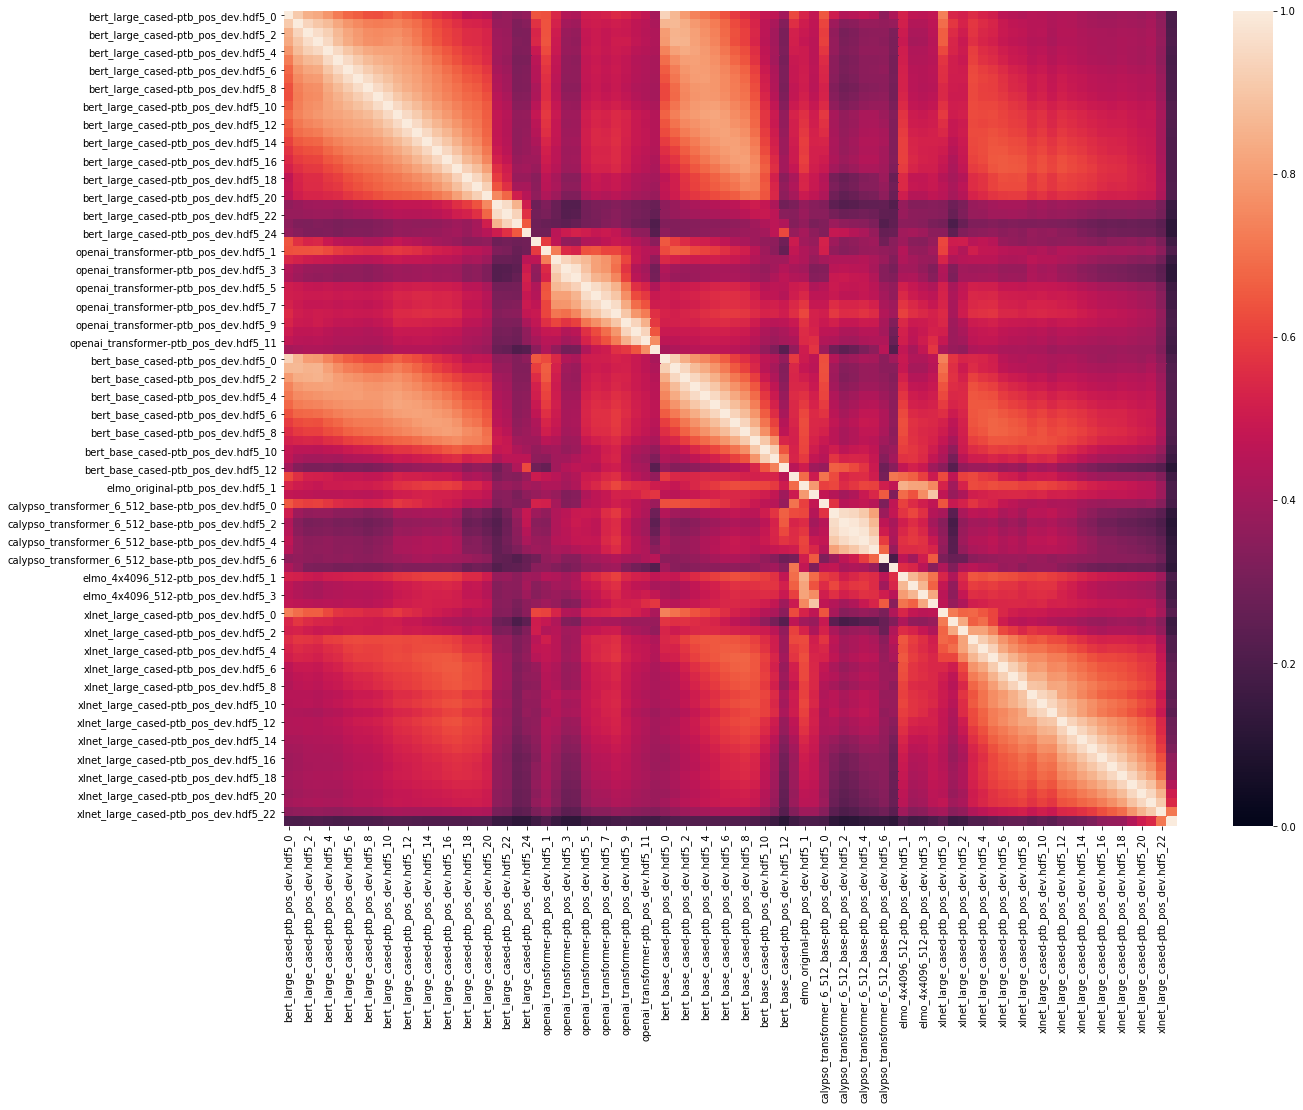

In [24]:
# lincka
sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1)

In [33]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [41]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_pw8_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [42]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_sv8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [43]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_maxmincorr8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [44]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_linregcorr8_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [38]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [39]:
# comparing models
# use lincka
model1 = "elmo"
model2 = "elmo"
cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

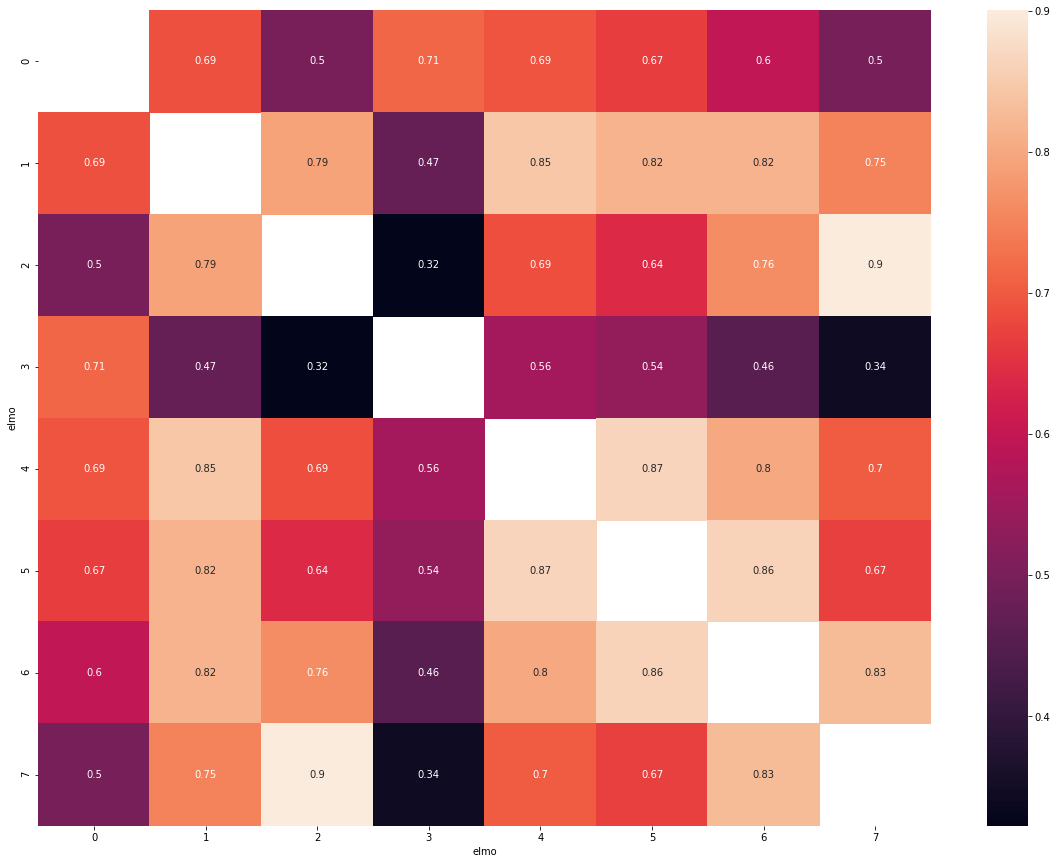

In [40]:
df = lincka_df.loc[rows, cols]

sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
plt.xlabel(model1)
plt.ylabel(model2)
plt.show()